<Figure size 1000x700 with 0 Axes>

Loaded tensor: (2, 149, 5264) (B,T,V)
Concatenated: (T=149, F=10528) with pq=2, V=5264
Windows: X=(146, 3, 10528), y=(146, 10528)
Breakdon: 116
Train: (116, 3, 10528), Test: (30, 3, 10528)
Normalization ON (minmax). Params learned on TRAIN only.


I0000 00:00:1761038527.700945   13522 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6205 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 OEM, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/500
1/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - loss: 1.5738e-04 - mae: 0.0017

2025-10-21 14:52:11.079471: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 1.5172e-04 - mae: 0.0017 - val_loss: 1.5542e-04 - val_mae: 0.0018
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.4532e-04 - mae: 0.0017 - val_loss: 1.4878e-04 - val_mae: 0.0019
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.3913e-04 - mae: 0.0019 - val_loss: 1.4233e-04 - val_mae: 0.0021
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.3294e-04 - mae: 0.0020 - val_loss: 1.3577e-04 - val_mae: 0.0022
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.2673e-04 - mae: 0.0021 - val_loss: 1.2869e-04 - val_mae: 0.0022
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.1974e-04 - mae: 0.0021 - val_loss: 1.2085e-04 - val_mae: 0.0023
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.1217e-04 - mae: 0.0021 - val_loss: 1.1208e-04 - val_mae: 0.0023
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.0388e-04 - mae: 0.0021 - val_loss: 1.0268e-04 - val_mae: 0.0023
Epoch 9/500
4/4 ━━━━

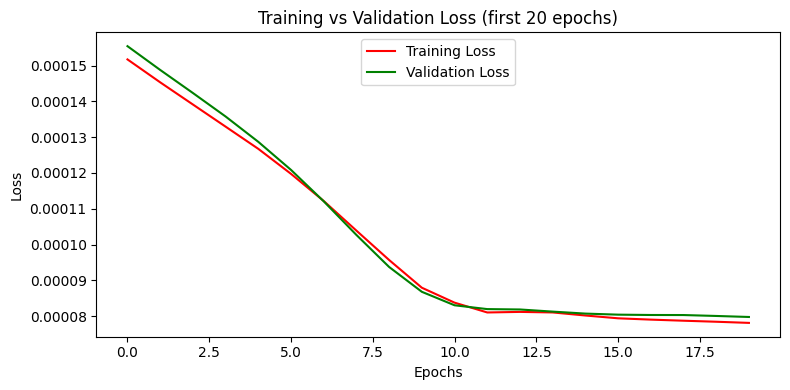

In [2]:
from matplotlib import pyplot as plt
plt.rcParams["figure.autolayout"] = True
plt.figure()
manager = plt.get_current_fig_manager()
manager.full_screen_toggle()
plt.show()
plt.rcParams["figure.figsize"] = [10.00, 7.00]
"""
Full pipeline with optional normalization:
Load → (optional normalize) → Train → Predict → Denormalize → Evaluate → Save → Visualize

Inputs
------
- big_tensor.npy : shape (B, T, V)  (aligned & zero-filled popularity vectors)

Main Features
-------------
1) Concatenate first `pq` big boxes along features → (T, pq*V)
2) Sliding windows of length `time_sequence` to predict next step
3) Compact model: TimeDistributed(Dense)->LSTM->Dense->Dense
4) Optional normalization (minmax or zscore), fit on TRAIN ONLY
5) Predict on test split; denormalize for metrics/saving
6) Save predictions/ground-truth (denormalized) and metrics
7) Visualize:
   - Training vs Validation loss curves
   - Actual vs Predicted (subset of dims)

Outputs
-------
- allresultpfresh.npy  : (pq, N_eval, V) predictions (denormalized, original scale)
- alltruefresh.npy     : (pq, N_eval, V) ground truth (denormalized, original scale)
- metrics_fresh.csv    : MAE/MSE per box + overall (original scale)
"""

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
TENSOR_PATH   = "big_UWP_tensor.npy"

pq            = 2            # number of big boxes concatenated along features
time_sequence = 3            # sliding window length
train_ratio   = 0.8          # chronological split

# Model sizes (reduce if you hit memory limits)
proj_dim      = 512          # per-timestep projection size
rnn_units     = 256          # LSTM units
learning_rate = 1e-3
batch_size    = 32
max_epochs    = 500
patience      = 10

# Normalization (toggle ON/OFF)
NORMALIZE          = True     # << set False to run without normalization
NORMALIZATION_TYPE = "minmax" # "minmax" or "zscore"

# Saving
SAVE_PRED     = "predictedUWP.npy"
SAVE_TRUE     = "truthUWP.npy"
SAVE_METRICS  = "metrics_freshUWP.csv"

# Visualization selection
VIS_SAMPLE_IDX = -1          # which test sample to visualize (-1 = last)
VIS_BOX_J      = 0           # which big box slice (0..pq-1)
VIS_K_MAX      = 2000        # first K dims to plot
# ----------------------------------------


def build_feature_matrix(pvect: np.ndarray, pq: int) -> np.ndarray:
    """Concatenate the first pq big boxes along features: (B,T,V) -> (T, pq*V)."""
    assert pq <= pvect.shape[0], "pq exceeds number of big boxes in tensor"
    parts = [pvect[i] for i in range(pq)]              # each (T, V)
    RCF = np.concatenate(parts, axis=1).astype(np.float32)
    return RCF


def make_windows(RCF: np.ndarray, time_sequence: int):
    """Build sliding windows: X: (N, ts, F), y: (N, F)."""
    T, F = RCF.shape
    X = np.array([RCF[i:i+time_sequence] for i in range(T - time_sequence)], dtype=np.float32)
    y = np.array([RCF[i+time_sequence]    for i in range(T - time_sequence)], dtype=np.float32)
    return X, y


def split_train_test(X, y, ratio: float):
    N = X.shape[0]
    split = int(ratio * N)
    print('Breakdon:',split)
    return X[:split], y[:split], X[split:], y[split:]


def build_model(time_sequence: int, F: int, proj_dim: int, rnn_units: int, lr: float):
    model = Sequential([
        Input(shape=(time_sequence, F)),
        TimeDistributed(Dense(proj_dim, activation="relu")),  # per-step compression
        LSTM(rnn_units),
        Dense(proj_dim, activation="relu"),
        Dense(F)                                             # back to full size
    ])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=["mae"])
    return model


def split_per_box(matrix_2d: np.ndarray, V: int):
    """(N, F=pq*V) -> (pq, N, V)"""
    N, F = matrix_2d.shape
    assert F % V == 0, "F must be multiple of V"
    _pq = F // V
    blocks = np.stack([matrix_2d[:, j*V:(j+1)*V] for j in range(_pq)], axis=0)
    return blocks


# ---------- Normalization helpers (fit on TRAIN ONLY) ----------
def fit_normalizer(train_data_2d: np.ndarray, method: str):
    """
    Fit normalization params on flattened train data.
    train_data_2d: shape (N_train, F)
    Returns params tuple depending on method.
    """
    if method == "minmax":
        mn = np.min(train_data_2d)
        mx = np.max(train_data_2d)
        return (mn, mx)
    elif method == "zscore":
        mean = np.mean(train_data_2d)
        std  = np.std(train_data_2d) + 1e-8
        return (mean, std)
    else:
        raise ValueError("Unknown normalization method")


def apply_normalizer(data_2d: np.ndarray, params, method: str):
    """Apply normalization to 2D data (N, F)."""
    if method == "minmax":
        mn, mx = params
        return (data_2d - mn) / (mx - mn + 1e-8)
    elif method == "zscore":
        mean, std = params
        return (data_2d - mean) / std
    else:
        raise ValueError("Unknown normalization method")


def invert_normalizer(data_2d: np.ndarray, params, method: str):
    """Invert normalization to original scale for 2D data (N, F)."""
    if method == "minmax":
        mn, mx = params
        return data_2d * (mx - mn + 1e-8) + mn
    elif method == "zscore":
        mean, std = params
        return data_2d * std + mean
    else:
        raise ValueError("Unknown normalization method")


# ---------------- Visualization ----------------
def visualize_loss(history):
    n = len(history.history.get("loss", []))
    m = min(20, n) if n > 0 else 0
    if m == 0:
        print("No loss history to plot.")
        return
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'][:m], c='r', label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'][:m], c='g', label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='upper center')
    plt.title(f"Training vs Validation Loss (first {m} epochs)")
    plt.tight_layout()
    plt.show()


def visualize_vectors(true_per_box, pred_per_box, box_j, sample_idx, k_max):
    V = true_per_box.shape[2]
    if true_per_box.shape[1] == 0:
        print("No samples to visualize.")
        return
    # normalize negative sample index
    si = sample_idx if sample_idx >= 0 else (true_per_box.shape[1] + sample_idx)
    si = max(0, min(si, true_per_box.shape[1] - 1))
    K = min(k_max, V)

    y_true_vec = true_per_box[box_j, si]
    y_pred_vec = pred_per_box[box_j, si]

    plt.figure(figsize=(12, 4))
    plt.plot(y_true_vec[:K], label="true", linewidth=1)
    plt.plot(y_pred_vec[:K], label="pred", linewidth=1)
    plt.title(f"Actual vs Predicted (Box {box_j}, sample {si})")
    plt.xlabel(f"small_id (first {K})")
    plt.ylabel("popularity count")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 1) Load tensor
pvect = np.load(TENSOR_PATH)  # (B, T, V)
B, T_total, V = pvect.shape
print(f"Loaded tensor: {pvect.shape} (B,T,V)")

# 2) Features
RCF = build_feature_matrix(pvect, pq)    # (T, pq*V)
T, F = RCF.shape
print(f"Concatenated: (T={T}, F={F}) with pq={pq}, V={V}")

# 3) Windows
X, y = make_windows(RCF, time_sequence)  # X: (N, ts, F), y: (N, F)
N = X.shape[0]
print(f"Windows: X={X.shape}, y={y.shape}")

# 4) Split
x_train, y_train, x_test, y_test = split_train_test(X, y, train_ratio)
print(f"Train: {x_train.shape}, Test: {x_test.shape}")

# 5) Optional normalization (fit on TRAIN ONLY)
if NORMALIZE:
    # Fit on train y (targets) and train X (inputs) using flattened 2D views
    y_train_2d = y_train.reshape(y_train.shape[0], -1)  # (N_train, F)
    params_y = fit_normalizer(y_train_2d, NORMALIZATION_TYPE)

    # Normalize y
    y_train = apply_normalizer(y_train_2d, params_y, NORMALIZATION_TYPE).reshape(y_train.shape)
    y_test  = apply_normalizer(y_test.reshape(y_test.shape[0], -1), params_y, NORMALIZATION_TYPE).reshape(y_test.shape)

    # Normalize X per feature as well using SAME params_y (simple, consistent)
    # (You could fit separate params for X; here we use y's params to keep scale aligned.)
    x_train = apply_normalizer(x_train.reshape(x_train.shape[0], -1), params_y, NORMALIZATION_TYPE).reshape(x_train.shape)
    x_test  = apply_normalizer(x_test.reshape(x_test.shape[0], -1), params_y, NORMALIZATION_TYPE).reshape(x_test.shape)

    print(f"Normalization ON ({NORMALIZATION_TYPE}). Params learned on TRAIN only.")
else:
    print("Normalization OFF.")

# 6) Model
model = build_model(time_sequence, F, proj_dim, rnn_units, learning_rate)
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=max_epochs,
    batch_size=batch_size,
    validation_data=(x_test, y_test),
    callbacks=[early],
    verbose=1
)

# 7) Loss curve
visualize_loss(history)


Breakdon: 0
Train: (0, 3, 10528), Test: (146, 3, 10528)
Predicted: (146, 10528)

=== Evaluation (Original Scale) ===
Box 0: MAE=0.410711  MSE=5.353111
Box 1: MAE=0.368830  MSE=5.045781
Overall: MAE=0.389770  MSE=5.199446

Saved predictions: predictedUWP.npy  shape=(2, 146, 5264)
Saved ground truth: truthUWP.npy  shape=(2, 146, 5264)
Saved metrics CSV: metrics_freshUWP.csv


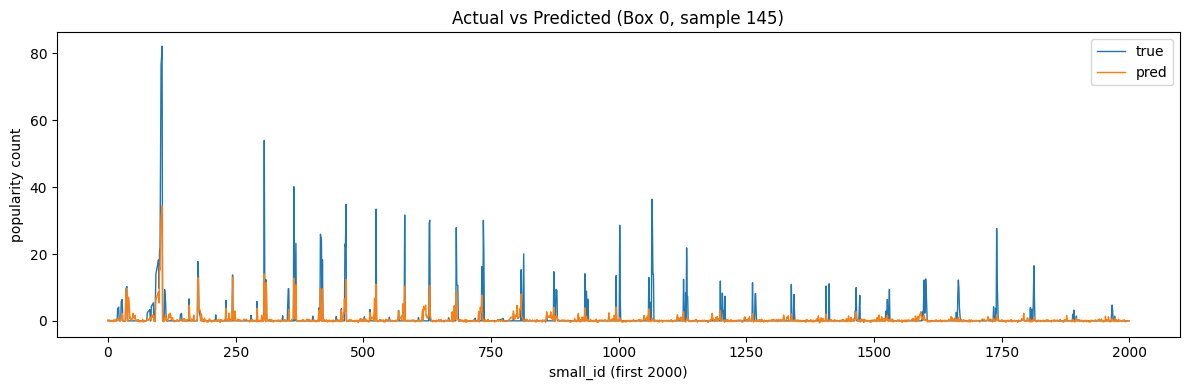

In [4]:
# 4) Split
x_train, y_train, x_test, y_test = split_train_test(X, y, 0.0)
print(f"Train: {x_train.shape}, Test: {x_test.shape}")

# 8) Predict on test
y_pred = model.predict(x_test, verbose=0)  # (N_eval, F)
N_eval = y_pred.shape[0]
print(f"Predicted: {y_pred.shape}")

# 9) Denormalize predictions & ground-truth back to original scale for metrics/saving
if NORMALIZE:
    y_pred = invert_normalizer(y_pred, params_y, NORMALIZATION_TYPE)
    y_test = invert_normalizer(y_test, params_y, NORMALIZATION_TYPE)

# 10) Split per box (pq, N_eval, V)
pred_per_box = split_per_box(y_pred, V)
true_per_box = split_per_box(y_test, V)

# 11) Metrics (original scale)
mae_per_box = np.mean(np.abs(pred_per_box - true_per_box), axis=(1,2))
mse_per_box = np.mean((pred_per_box - true_per_box) ** 2, axis=(1,2))
mae_overall = np.mean(np.abs(y_pred - y_test))
mse_overall = np.mean((y_pred - y_test) ** 2)

print("\n=== Evaluation (Original Scale) ===")
for j in range(pq):
    print(f"Box {j}: MAE={mae_per_box[j]:.6f}  MSE={mse_per_box[j]:.6f}")
print(f"Overall: MAE={mae_overall:.6f}  MSE={mse_overall:.6f}")

# 12) Save outputs
save_dir = os.path.dirname(SAVE_PRED)
if save_dir != "":
    os.makedirs(save_dir, exist_ok=True)
np.save(SAVE_PRED, pred_per_box)  # (pq, N_eval, V)
np.save(SAVE_TRUE, true_per_box)  # (pq, N_eval, V)
with open(SAVE_METRICS, "w") as f:
    f.write("box,mae,mse\n")
    for j in range(pq):
        f.write(f"{j},{mae_per_box[j]},{mse_per_box[j]}\n")
    f.write(f"overall,{mae_overall},{mse_overall}\n")

print(f"\nSaved predictions: {SAVE_PRED}  shape={pred_per_box.shape}")
print(f"Saved ground truth: {SAVE_TRUE}  shape={true_per_box.shape}")
print(f"Saved metrics CSV: {SAVE_METRICS}")

# 13) Visualization: Actual vs Predicted (subset of dims)
if N_eval > 0:
    visualize_vectors(true_per_box, pred_per_box,
                      box_j=VIS_BOX_J, sample_idx=VIS_SAMPLE_IDX, k_max=VIS_K_MAX)
else:
    print("No evaluation samples to visualize.")

In [ ]:
'''
Construct per–cellular-area (big box) map-segment request sequences, one per timeslot, 
using a sliding window of the most recent `time_sequence` steps. Because the downstream model
is LSTM-based, both inputs and targets are temporally aligned: for each index t, the input window 
aggregates the last `time_sequence` slots [t−time_sequence, …, t−1], and the corresponding map-request data 
(targets) is taken at the next slot t. This ensures the training data reflects causal, ordered context consistent 
with UWP-driven demand dynamics.
'''
car4=np.load('car4real.npy',allow_pickle=True)[0]
Timeslot=list(car4[21].keys())
CELLULAR=[21,22]
MP=[]
for q in CELLULAR:
    car10=car4[q]
    carr10=[]
    for i in range(149):
        carr10.append(car10[Timeslot[i]])
    for el in carr10:
        el.sort(key=lambda x: x[1])
    mapsegment=[]
    for p in range(len(carr10)):
        cachep={}
        for i in range(1,7):
            cachep[i]=[]
        for slot in carr10[p]:
            for el in slot[2]:
                cachep[int(slot[1]/10)+1].append([(el[0]),(el[1])])
        mapsegment.append(cachep)
    MP.append(mapsegment)
mpti=[]
mpto=[]
for el in MP:
    mpti.append([[el[i+j] for j in range(time_sequence)] for i in range(len(el)-time_sequence)])
    mpto.append([[el[i+time_sequence]] for i in range(len(el)-time_sequence)]) 

np.save('map_requests.npy',mpto)